# Общая модель

## Импорт библиотек

In [97]:
import cv2
import tensorflow as tf
import numpy as np
from PIL import Image
from keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Conv2DTranspose, Input, Concatenate, MaxPooling2D, Dropout, LSTM, \
Bidirectional, Reshape, Dense
from tensorflow.keras import backend as K
from keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
import os

In [98]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Разрешить динамическое выделение памяти на GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

### Класс для HTR Модели

In [99]:
alphabets = 'KКПu}ЗR<лLC4Gm:O28БbЕЧя-fИНЭ’зiЮнВpьЩпгШ|ашIr\'EР _k>)tдфw0SXГyб7c"(5MЦйуTF=/ыД6»xPр;ек*AТ9цжdH3zочЖlФvNY+JХмт.«e[Йh\\ЁWМB!ъgАх?щэЫV\n]nsЯсСв,aoDУОю№1иёЛ'

In [100]:
class HTRModel:
    def __init__(self, alphabets, max_str_len, num_of_characters, num_of_timestamps, htr_weights_path, target_size=(128, 32)):
        self.alphabets = alphabets
        self.max_str_len = max_str_len
        self.num_of_characters = num_of_characters
        self.num_of_timestamps = num_of_timestamps
        self.htr_weights_path = htr_weights_path
        self.target_size = target_size


    def __num_to_label(self, num):
        ret = ""
        for ch in num:
            if ch == -1:  # CTC Blank
                break
            else:
                ret+=self.alphabets[ch]
        return ret

    def __get_model(self):
        input_data = Input(shape=(self.target_size[0], self.target_size[1], 1), name='input')

        inner = Conv2D(16, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
        inner = BatchNormalization()(inner)
        inner = Activation('relu')(inner)
        inner = Conv2D(32, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(input_data)  
        inner = BatchNormalization()(inner)
        inner = Activation('relu')(inner)
        inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

        inner = Conv2D(64, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
        inner = BatchNormalization()(inner)
        inner = Activation('relu')(inner)
        inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
        inner = Dropout(0.5)(inner)

        inner = Conv2D(128, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(inner)
        inner = BatchNormalization()(inner)
        inner = Activation('relu')(inner)
        inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
        inner = Dropout(0.5)(inner)

        # b to c
        inner = Reshape(target_shape=((64, 256)), name='reshape')(inner)
        inner = Dense(512, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

        ## RNN
        inner = Bidirectional(LSTM(256, return_sequences=True, dropout=0.3), name = 'lstm1')(inner)
        inner = Bidirectional(LSTM(256, return_sequences=True, dropout=0.3), name = 'lstm2')(inner)

        # Выходной слой
        inner = Dense(self.num_of_characters, kernel_initializer='he_normal', name='dense3')(inner)
        y_pred = Activation('softmax', name='softmax')(inner)

        # Модель
        model = Model(inputs=input_data, outputs=y_pred)

        return model

    
    def predict_words(self, segments):
        model = self.__get_model()
        model.load_weights(self.htr_weights_path)

        preds = model.predict(segments)
        decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                        greedy=True)[0][0])

        prediction = []
        for i in range(len(decoded)):
            prediction.append(self.__num_to_label(decoded[i]))

        return prediction



In [101]:
model = HTRModel(alphabets, 40, len(alphabets) + 1, 64, "recognizer_model.weights.h5")

## Класс для извлечения текста и его распознавания

In [105]:
class TextRecognition:
    def __init__(self, images_paths, target_size, seg_weights_path, htr_model, segment_threshold=0.5):
        self.images_paths = images_paths
        self.target_size = target_size
        self.seg_weights_path = seg_weights_path
        self.segment_threshold = segment_threshold
        self.htr_model = htr_model
    
    def __prepare_image(self, image_path):
        image = Image.open(image_path).convert("RGB")
        image = np.array(image) / 255.0  # Нормализация пикселей
        resized_image = cv2.resize(image, self.target_size, interpolation=cv2.INTER_CUBIC)
        return resized_image
    
    def __conv_block(self, inputs, num_filters):
        x = Conv2D(num_filters, 3, padding="same")(inputs)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

        x = Conv2D(num_filters, 3, padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

        return x

    def __decoder_block(self, inputs, skip_features, num_filters):
        x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
        x = Concatenate()([x, skip_features])
        x = self.__conv_block(x, num_filters)

        return x

    def __build_unet_resnet_model(self, channels=3):
        '''Input layer'''
        inputs = Input((self.target_size[0], self.target_size[1], channels))
        
        '''Pre-trained ResNet50V2'''
        resnet50 = ResNet50V2(include_top=False, weights="imagenet", input_tensor=inputs)

        for layer in resnet50.layers:
            layer.trainable = False
        
        '''Skip connections'''
        s1 = inputs  # 1024
        s2 = resnet50.get_layer("conv1_conv").output  # 512
        s3 = resnet50.get_layer("conv2_block3_1_relu").output  # 256
        s4 = resnet50.get_layer("conv3_block4_1_relu").output  # 128

        '''Bridge'''
        b1 = resnet50.get_layer("conv4_block6_1_relu").output  # 64

        '''Decoder'''
        d1 = self.__decoder_block(b1, s4, 256)  # 128
        d2 = self.__decoder_block(d1, s3, 128)  # 256
        d3 = self.__decoder_block(d2, s2, 64)  # 512
        d4 = self.__decoder_block(d3, s1, 32)  # 1024

        '''Output Layer'''
        outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
        
        model = Model(inputs, outputs)
        return model

    def __get_segmentation(self, images):
        model = self.__build_unet_resnet_model()
        model.load_weights(self.seg_weights_path)
        pred_mask = model.predict(images)
        binary_prediction = (pred_mask >= self.segment_threshold).astype(np.uint8)
        return binary_prediction

    def __adjust_contrast(self, image):
        return tf.image.adjust_contrast(image, 2)

    def __distortion_free_resize(self, image, img_size):
        w, h = img_size
        image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

        # Определяем отступы
        pad_height = h - tf.shape(image)[0]
        pad_width = w - tf.shape(image)[1]

        pad_height_top = pad_height // 2
        pad_height_bottom = pad_height - pad_height_top
        pad_width_left = pad_width // 2
        pad_width_right = pad_width - pad_width_left

        image = tf.pad(
            image,
            paddings=[
                [pad_height_top, pad_height_bottom],
                [pad_width_left, pad_width_right],
                [0, 0]
            ]
        )

        image = tf.transpose(image, perm=[1, 0, 2])
        image = tf.image.flip_left_right(image)

        return image

    # ✅ Исправленный метод для обработки изображений в виде list
    def __preprocess_image(self, image_list, target_size=(128, 32)):
        # Преобразуем list в numpy-массив, затем в tf.Tensor
        image = tf.convert_to_tensor(np.array(image_list), dtype=tf.float32)

        # Если изображение 2D, добавляем канал (ч/б изображение)
        if len(tf.shape(image)) == 2:
            image = tf.expand_dims(image, axis=-1)

        if tf.shape(image)[-1] == 3:
            image = tf.image.rgb_to_grayscale(image)

        image = self.__distortion_free_resize(image, target_size)
        image = self.__adjust_contrast(image)
        image = tf.image.per_image_standardization(image)

        return image
    
    def __extract_word_segments(self, image_np, mask):
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        word_segments = []

        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            cropped_word = image_np[y:y + h, x:x + w].copy()

            word_segments.append(cropped_word)
        
        return word_segments
    
    def extract_words(self):
        images = [self.__prepare_image(image_path) for image_path in self.images_paths]
        images = np.array(images)
        pred_segments = self.__get_segmentation(images)

        all_words_segments = []
        
        for image_index, segmented_mask in enumerate(pred_segments):
            image_np = (images[image_index] * 255).astype(np.uint8)
            words_segments = self.__extract_word_segments(image_np, segmented_mask)
            all_words_segments.extend(words_segments)

        preds_segments = [self.__preprocess_image(segment) for segment in all_words_segments]

        preds_words = self.htr_model.predict_words(tf.stack(preds_segments))

        return preds_segments, preds_words


## Проверка на примере

In [106]:
seg_weights_path = "segmentation_resnet_unet_model.weights.h5"

TR_Model = TextRecognition(["images/1_19.jpg"], (1024, 1024), seg_weights_path, model)

In [107]:
segments, words = TR_Model.extract_words()

2/2 [==============================] - 1s 9ms/step


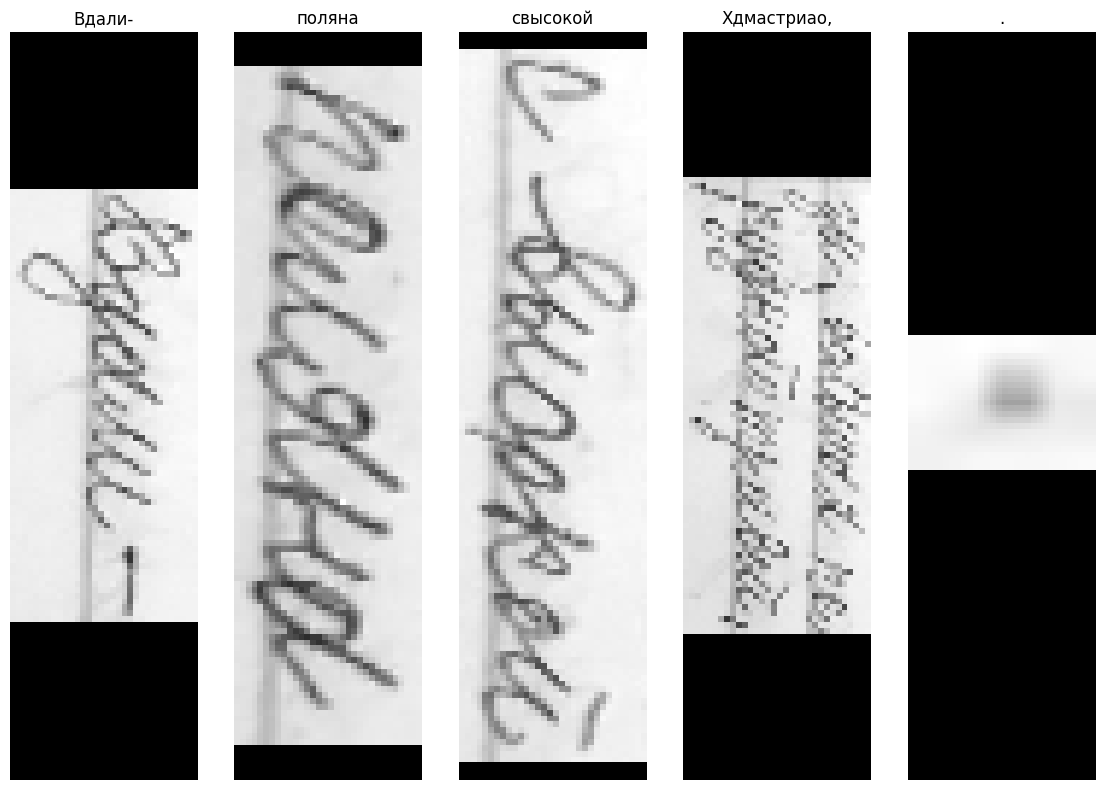

In [110]:
plt.figure(figsize=(14, 14))
for index, segment in enumerate(segments[:5]):
    plt.subplot(1, len(segments[:5]), index+1)
    plt.imshow(segment, cmap="gray")
    plt.title(words[index])
    plt.axis("off")

plt.show()